# imports and defs

In [1]:
import utility_module_2_v_3 as uu
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy.matlib as ml
from datetime import datetime
from tqdm import tqdm
import copy


In [2]:
path_imd='/media/vikram/subimal/Raw_Data/IMD_DATA/'
path_gcm = '/media/vikram/subimal/Raw_Data/GCM_BCSD_DATA/'


# Read IMD  data

## Read data

In [3]:
data_bounds=[65, 40, 100, 5]
st=1901
en=2005
yr_split = 1951
data_imd_obs,m,lat_obs,lon_obs=uu.extract_imd_rainfall_nc(st,en,path_imd+'/rainfall_pt1/',data_bounds)
mask=np.all(m,axis=0)

dict_keys(['time', 'lon', 'lat', 'rainfall'])


## Data check

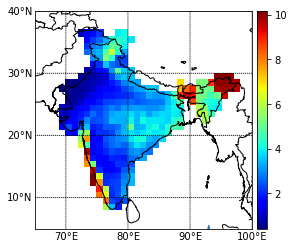

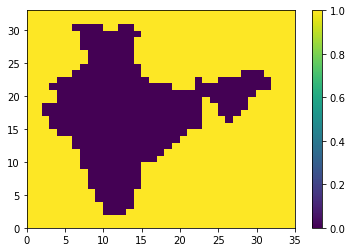

In [4]:
# plot spatial
map_bounds=data_bounds
mp_spacing=10
uu.map_plot_cyl(np.mean(data_imd_obs[:,:,:],axis=0),lat_obs,lon_obs,map_bounds,mp_spacing=10)

# plot temporal
plt.plot(data_imd_obs[:365*5,15,15])
plt.plot(data_imd_obs[-365*5:,15,15])

# plot mask
plt.figure()
plt.pcolor(mask)
plt.colorbar()

## Fill outside the mask

In [5]:
def create_distance_matrix(M,N,ii,jj):
  D=np.ones((M,N))*10000000
  for i in range(M):
    for j in range(N):
      D[i,j]=np.abs(i-ii)**2+0.1*np.abs(j-jj)**2
  return D

N1=data_imd_obs.shape[1]
N2=data_imd_obs.shape[2]
data_new= copy.deepcopy(data_imd_obs)
for i in range(N1):
  for j in range(N2):
    if mask[i,j]==1:
      a=create_distance_matrix(N1,N2,i,j)+1000000*mask
      i_min,j_min= np.unravel_index(a.argmin(), a.shape)
      data_new[:,i,j]=data_imd_obs[:,i_min,j_min]

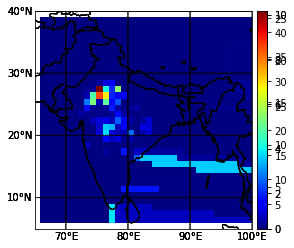

In [6]:
uu.map_plot_cyl(np.mean(data_new,axis=0),lat_obs,lon_obs,map_bounds,mp_spacing=10)
uu.map_plot_cyl(np.mean(data_imd_obs,axis=0),lat_obs,lon_obs,map_bounds,mp_spacing=10)
uu.map_plot_cyl(data_new[1,:,:],lat_obs,lon_obs,map_bounds,mp_spacing=10)
uu.map_plot_cyl(data_new[7,:,:],lat_obs,lon_obs,map_bounds,mp_spacing=10)
data_imd_obs= copy.deepcopy(data_new)
del data_new

# Read GCM

In [7]:
from netCDF4 import Dataset

date_ts=pd.date_range(start=str(st)+'-01-01',end=str(en)+'-12-31')
print(date_ts[0],date_ts[-1])
N=date_ts.shape[0]
print("N:1901-2005::",st,en,N,105*(365.25))

1901-01-01 00:00:00 2005-12-31 00:00:00
N:1901-2005:: 1901 2005 38351 38351.25


## MIROC_ESM

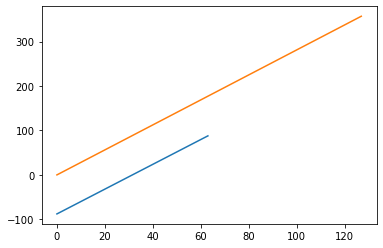

In [65]:
# reading file(s)GFDL_CM3CanESM2MIROC_ESM
filename = path_gcm + '/MIROC_ESM/pr_day_MIROC-ESM_historical_r1i1p1_18500101-20051231.nc'
fh = Dataset(filename, mode='r')
lons = fh.variables['lon'][:]
lats = fh.variables['lat'][:]
plt.plot(lats)
plt.plot(lons)
# cropping the study area out
l_lat,u_lat,lat_gcm=uu.find_bounds(lats,data_bounds[3],data_bounds[1])
l_lon,u_lon,lon_gcm=uu.find_bounds(lons,data_bounds[0],data_bounds[2])

# cropping years before 1901
st_gcm=1850
dt_data_st=np.datetime64(str(st_gcm)+'-01-01')
dt_st=np.datetime64(str(st)+'-01-01')
index_of_st=((dt_st- dt_data_st) / np.timedelta64(1, 'D')).astype(int)

data_gcm_daily = fh.variables['pr'][index_of_st:,l_lat:u_lat+1,l_lon:u_lon+1].data*3600*24



In [66]:
print(data_gcm_daily.shape,lat_gcm.shape,lon_gcm.shape,st_gcm)

(38351, 14, 14) (14,) (14,) 1850


In [67]:
gcm_name='MIROC_ESM'

## CanESM
Input file 
- contains one file \
- no leap year

38325 == 38325


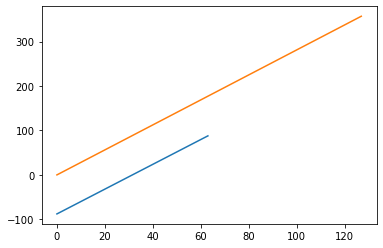

In [8]:
# reading file(s)
gcm_name='CanESM2'
filename = path_gcm + '/CanESM2/pr_day_CanESM2_historical_r1i1p1_18500101-20051231.nc'
fh = Dataset(filename, mode='r')
lons = fh.variables['lon'][:]
lats = fh.variables['lat'][:]
plt.plot(lats)
plt.plot(lons)
# cropping the study area out
l_lat,u_lat,lat_gcm=uu.find_bounds(lats,data_bounds[3],data_bounds[1])
l_lon,u_lon,lon_gcm=uu.find_bounds(lons,data_bounds[0],data_bounds[2])

# cropping years before 1901
st_gcm=1850
dt_st=1901
index_of_st=(dt_st- st_gcm) *365

#print(fh)
data_gcm_daily = fh.variables['pr'][index_of_st:,l_lat:u_lat+1,l_lon:u_lon+1].data*3600*24
print(data_gcm_daily.shape[0],"==",365*105)
data_gcm_daily=uu.add_leap_years_sts(data_gcm_daily,st,en)[0]

In [9]:
print(data_gcm_daily.shape,N-data_gcm_daily.shape[0],lat_gcm.shape,lon_gcm.shape,st_gcm)

(38351, 14, 14) 0 (14,) (14,) 1850


## GFDL_CM3
Input files:
- 5 year files
- no leap years


In [188]:
delta=5
gcm_name='GFDL_CM3'
st_gcm=1901
def get_fname(var,str1,str2):
  url= path_gcm + '/GFDL_CM3/'+var+'_day_GFDL-CM3_historical_r1i1p1_'+str1+'-'+str2+'.nc'
  return url

def get_urls(var):
  fname_list=[]
  for yeaR in range(1900,2004,delta):
    str1=str(yeaR)+'0101'
    str2=str(yeaR+delta-1)+'1231'
    
    fname_list.append(get_fname(var,str1,str2))

  str1=str(2005)+'0101'
  str2=str(2005)+'1231'
  
  fname_list.append(get_fname(var,str1,str2))
  return fname_list


fnames=get_urls('pr')

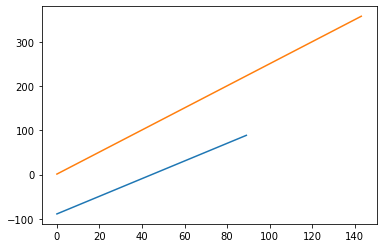

In [189]:
# reading file(s)
filename = fnames[0]
fh = Dataset(filename, mode='r')
lons = fh.variables['lon'][:]
lats = fh.variables['lat'][:]
plt.plot(lats)
plt.plot(lons)
# cropping the study area out
l_lat,u_lat,lat_gcm=uu.find_bounds(lats,data_bounds[3],data_bounds[1])
l_lon,u_lon,lon_gcm=uu.find_bounds(lons,data_bounds[0],data_bounds[2])

for i in range(len(fnames)):
  filename = fnames[i]
  fh = Dataset(filename, mode='r')
  lons = fh.variables['lon'][:]
  lats = fh.variables['lat'][:]
  #print(fh)
  data = fh.variables['pr'][:,l_lat:u_lat+1,l_lon:u_lon+1].data * 3600*24

  if i==0:
    # starts at 1901
    data_gcm_daily=data[365:,:,:]
  else:
    data_gcm_daily=np.concatenate((data_gcm_daily,data),axis=0)
data_gcm_daily=uu.add_leap_years_sts(data_gcm_daily,st,en)[0]

In [190]:
print(data_gcm_daily.shape,N-data_gcm_daily.shape[0],lat_gcm.shape,lon_gcm.shape,st_gcm)

(38351, 19, 16) 0 (19,) (16,) 1901


## Other ESMs
Input file 
- contains one file \
- no leap year

In [9]:
st

1901

In [ ]:
# /media/vikram/One Touch/New CMIP5/CNRM_CM5/pr_day_CNRM-CM5_historical_r1i1p1_19000101-20051231.nc
# /media/vikram/One Touch/New CMIP5/ACCESS1_0/pr_day_ACCESS1-0_historical_r1i1p1_19000101-20051231.nc
# /media/vikram/One Touch/New CMIP5/NorESM1_M/pr_day_NorESM1-M_historical_r1i1p1_19000101-20051231.nc
# /media/vikram/One Touch/New CMIP5/CM5A_LR/pr_day_IPSL-CM5A-LR_historical_r1i1p1_18500101-20051231.nc
# /media/vikram/One Touch/New CMIP5/MPI_ESM_MR/pr_day_MPI-ESM-MR_historical_r1i1p1_19000101-20051231.nc
# /media/vikram/One Touch/New CMIP5/MRI_ESM1/pr_day_MRI-ESM1_historical_r1i1p1_19010101-20051231.nc


In [ ]:
'MRI_ESM1','ACCESS1_0','NorESM1_M','CM5A_LR','CNRM_CM5','MPI_ESM_MR'

(38716, 96, 192) (38716,) 38690
38351 == 38325


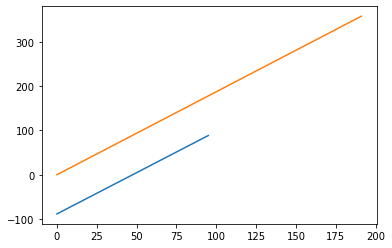

In [67]:
# reading file(s)
path_gcm  = "/media/vikram/One Touch/New CMIP5/"

gcm_name='MRI_ESM1'
filename = path_gcm + 'MRI_ESM1/pr_day_MRI-ESM1_historical_r1i1p1_19010101-20051231.nc'
st_gcm=1901


gcm_name='ACCESS1_0'
filename = path_gcm + 'ACCESS1_0/pr_day_ACCESS1-0_historical_r1i1p1_19000101-20051231.nc'
st_gcm=1900


gcm_name='NorESM1_M'
filename = path_gcm + 'NorESM1_M/pr_day_NorESM1-M_historical_r1i1p1_19000101-20051231.nc'
st_gcm=1900


gcm_name='CM5A_LR'
filename = path_gcm + 'CM5A_LR/pr_day_IPSL-CM5A-LR_historical_r1i1p1_18500101-20051231.nc'
st_gcm=1850


gcm_name='CNRM_CM5'
filename = path_gcm + 'CNRM_CM5/pr_day_CNRM-CM5_historical_r1i1p1_19000101-20051231.nc'
st_gcm=1900


gcm_name='MPI_ESM_MR'
filename = path_gcm + 'MPI_ESM_MR/pr_day_MPI-ESM-MR_historical_r1i1p1_19000101-20051231.nc'
st_gcm=1900



fh = Dataset(filename, mode='r')
lons = fh.variables['lon'][:]
lats = fh.variables['lat'][:]
plt.plot(lats)
plt.plot(lons)
# cropping the study area out
l_lat,u_lat,lat_gcm=uu.find_bounds(lats,data_bounds[3],data_bounds[1])
l_lon,u_lon,lon_gcm=uu.find_bounds(lons,data_bounds[0],data_bounds[2])


date_gcms = pd.date_range(start=str(st_gcm) + "/01/01",end="2005/12/31",freq = "D")
print(fh.variables['pr'].shape,date_gcms.shape,365*(2005 - st_gcm+1))

# cropping years before 1901
dt_data_st=np.datetime64(str(st_gcm)+'-01-01')
dt_st=np.datetime64(str(st)+'-01-01')
index_of_st=((dt_st- dt_data_st) / np.timedelta64(1, 'D')).astype(int)



# dt_st=1901
# index_of_st=(st- st_gcm) *365


data_gcm_daily = fh.variables['pr'][index_of_st:,l_lat:u_lat+1,l_lon:u_lon+1].data*3600*24
print(data_gcm_daily.shape[0],"==",365*105)
# data_gcm_daily=uu.add_leap_years_sts(data_gcm_daily,st,en)[0]

# Continuous Train/test split

In [10]:
path_out = '/home/vikram/BCSD_data/India_P_BCSDd/'
!mkdir "/home/vikram/BCSD_data/India_P_BCSDd/"

mkdir: cannot create directory ‘/home/vikram/BCSD_data/India_P_BCSDd/’: File exists


## Split obs data

In [11]:
data_imd_obs.shape

(38351, 33, 35)

In [12]:
data_imd_obs = uu.remove_leap_years_sts(data_imd_obs,st,en)[0]

In [13]:
yr_split = 1951
Nyears_train = yr_split - st 
Nyears_test =  en -  st +1

data_obs_imd_train = data_imd_obs[:365*Nyears_train,:,:].data
data_obs_imd_pred = data_imd_obs.data

print(data_imd_obs.shape,data_obs_imd_train.shape,data_obs_imd_pred.shape)

(38325, 33, 35) (18250, 33, 35) (38325, 33, 35)


## split gcm data

In [14]:
data_gcm_daily.shape

(38351, 14, 14)

In [15]:
data_gcm_daily = uu.remove_leap_years_sts(data_gcm_daily,st,en)[0]

In [18]:
data_gcm_train = data_gcm_daily[:365*Nyears_train,:,:]
data_gcm_pred = data_gcm_daily[:,:,:]

print(data_gcm_daily.shape,data_gcm_train.shape,data_gcm_pred.shape)

(38325, 14, 14) (18250, 14, 14) (38325, 14, 14)


## Reading future data

(34698, 128, 256) (34698,) 34675
34698 == 34675


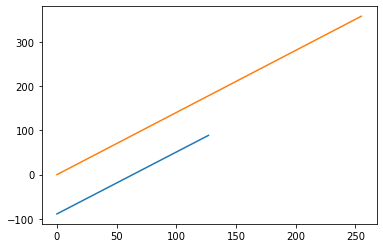

In [76]:
# reading file(s)
st_future = 2006
en_future = 2100

path_gcm  = "/media/vikram/One Touch/New CMIP5/"

gcm_name='CanESM2'
filename = path_gcm + '/rcp85/CansESM2/pr_day_CanESM2_rcp85_r1i1p1_20060101-21001231.nc'
st_gcm=2006

gcm_name='GFDL_CM3'
filename ="/media/vikram/One Touch/New CMIP5/rcp85/GFDL_CM3/pr_day_GFDL-CM3_rcp85_r1i1p1_20060101-21001231.nc"

gcm_name='NorESM1_M'
filename = "/media/vikram/One Touch/New CMIP5/rcp85/NorESM/pr_day_NorESM1-M_rcp85_r1i1p1_20060101-21001231.nc"

gcm_name='CM5A_LR'
filename ="/media/vikram/One Touch/New CMIP5/rcp85/IPSL_CM5A/pr_day_IPSL-CM5A-LR_rcp85_r1i1p1_20060101-22051231.nc"


gcm_name='MPI_ESM_MR'
filename ="/media/vikram/One Touch/New CMIP5/rcp85/MPI_ESM_MR/pr_day_MPI-ESM-MR_rcp85_r1i1p1_20060101-21001231.nc"

gcm_name='MRI_ESM1'
filename = "/media/vikram/One Touch/New CMIP5/rcp85/MRI_ESM/pr_day_MRI-ESM1_rcp85_r1i1p1_20060101-21001231.nc"

gcm_name='MIROC_ESM'
filename = "/media/vikram/One Touch/New CMIP5/rcp85/MIROC_ESM/pr_day_MIROC-ESM_rcp85_r1i1p1_20060101-21001231.nc"

gcm_name='ACCESS1_0'
filename = "/media/vikram/One Touch/New CMIP5/rcp85/ACCESS1_0/pr_day_ACCESS1-0_rcp85_r1i1p1_20060101-21001231.nc"

gcm_name='CNRM_CM5'
filename = "/media/vikram/One Touch/New CMIP5/rcp85/CNRM_CM5/pr_day_CNRM-CM5_rcp85_r1i1p1_20060101-21001231.nc"


fh = Dataset(filename, mode='r')
lons = fh.variables['lon'][:]
lats = fh.variables['lat'][:]
plt.plot(lats)
plt.plot(lons)
# cropping the study area out
l_lat,u_lat,lat_gcm=uu.find_bounds(lats,data_bounds[3],data_bounds[1])
l_lon,u_lon,lon_gcm=uu.find_bounds(lons,data_bounds[0],data_bounds[2])


date_gcms = pd.date_range(start=str(st_gcm) + "/01/01",end="2100/12/31",freq = "D")
print(fh.variables['pr'].shape,date_gcms.shape,365*(2100 - st_gcm+1))

# cropping years before 1901
dt_data_st=np.datetime64(str(st_gcm)+'-01-01')
dt_st=np.datetime64(str(st_future)+'-01-01')
dt_en=np.datetime64(str(en_future+1)+'-01-01')
index_of_st=((dt_st- dt_data_st) / np.timedelta64(1, 'D')).astype(int)
index_of_en=((dt_en- dt_data_st) / np.timedelta64(1, 'D')).astype(int)

# dt_st=2006
# index_of_st=(st_future- st_gcm) *365
# index_of_en=(en_future + 1 - st_gcm) *365 

data_gcm_future = fh.variables['pr'][index_of_st:index_of_en,l_lat:u_lat+1,l_lon:u_lon+1].data*3600*24
print(data_gcm_future.shape[0],"==",365*95)

data_gcm_future = uu.remove_leap_years_sts(data_gcm_future,st_future,en_future)[0]


In [77]:
print(data_gcm_future.shape[0],"==",365*95)


34675 == 34675


## Writing Variables

In [78]:
gcm_name

'CNRM_CM5'

In [79]:
np.save(path_out + '/data_gcm_'+gcm_name+'_future',data_gcm_future)


In [31]:
np.save(path_out + '/data_obs_imd_train',data_obs_imd_train)

data_obs_imd_pred_coarse=np.zeros((data_obs_imd_pred.shape[0],data_gcm_pred.shape[1],data_gcm_pred.shape[2]))
for i in range(data_obs_imd_pred.shape[0]):
    data_obs_imd_pred_coarse[i,:,:]=uu.regrid(data_obs_imd_pred[i,:,:],lat_obs,lon_obs,lat_gcm,lon_gcm)

np.save(path_out + '/data_obs_imd_'+gcm_name+'_pred_coarse',data_obs_imd_pred_coarse)
np.save(path_out + '/data_obs_imd_pred',data_obs_imd_pred)


np.save(path_out + '/data_gcm_'+gcm_name+'_imd_pred',data_gcm_pred)
np.save(path_out + '/data_gcm_'+gcm_name+'_imd_train',data_gcm_train)
np.save(path_out + '/data_gcm_'+gcm_name+'_future',data_gcm_future)

                          
                          
metadata={'st':st,
     'en':en,
     'Nyears_train':Nyears_train,
     'Nyears_test':Nyears_test,
     'mask':mask,
     'data_bounds':data_bounds,
     'path_out':path_out,
     'lat_obs':lat_obs,
     'lat_gcm':lat_gcm,
     'lon_obs':lon_obs,
     'lon_gcm':lon_gcm}     
     
np.save(path_out + '/bcsd_imd_metadata_'+gcm_name,metadata)


# warm cold years split

In [98]:
path_out = '/home/vikram/BCSD_data/India_P_BCSDd_CH_eqm/'
!mkdir "/home/vikram/BCSD_data/India_P_BCSDd_CH_eqm/"

mkdir: cannot create directory ‘/home/vikram/BCSD_data/India_P_BCSDd_CH_eqm/’: File exists


In [35]:
with np.load('/home/vikram/Dropbox/BCSD Work/07_BCSD_India_salvi/cold_warm_years.npz',allow_pickle=True) as dataz:
    train_years = dataz['cold_years']
    test_years = dataz['warm_years']

_,N1,N2 = data_imd_obs.shape

data_obs_imd_noleap_yearwise = data_imd_obs.reshape((365,-1,N1,N2),
                                       order='F').data

data_obs_imd_train  = data_obs_imd_noleap_yearwise[:,np.sort( train_years - st),:,:].reshape([-1,N1,N2]
                                                ,order = 'F' )

data_obs_imd_other  = data_obs_imd_noleap_yearwise[:,np.sort( test_years - st),:,:].reshape([-1,N1,N2]
                                                ,order = 'F' )

data_obs_imd_pred = np.concatenate((data_obs_imd_train,data_obs_imd_train),axis = 0)
Nyears_train = train_years.shape[0]
Nyears_test = test_years.shape[0]+train_years.shape[0]

print(data_imd_obs.shape,data_obs_imd_train.shape,data_obs_imd_pred.shape,Nyears_train*365,Nyears_test*365)


(38325, 33, 35) (9855, 33, 35) (19710, 33, 35) 9855 19710


# warm_cold_years in gcm

In [36]:
data_tas = np.load('/home/vikram/BCSD_data/India_T_BCSDd_new/data_gcm_CanESM2_imd_pred.npy')

In [37]:
data_tas.shape

(20075, 14, 14)

Monthly data dimensions: (660, 14, 14)
(55, 14, 14)


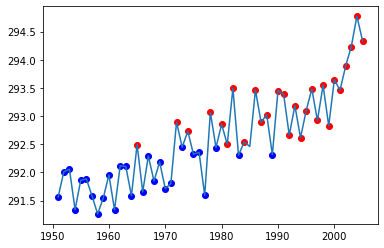

In [38]:
data_monthly = uu.daily_to_monthly_sts(data_tas,1951,2005,method='MEAN')
data_annual = np.mean(np.reshape(data_monthly,(12,-1,14,14),order = 'F')[2:5],axis=0)
annual_ts = np.nanmean(data_annual,axis=(1,2))
print(data_annual.shape)
plt.plot(range(1951,2005+1,1),annual_ts)
# data_annual[0,:,:]

# plt.plot(np.sort(annual_ts))
min_years=np.argsort(annual_ts)[:27]
max_years=np.argsort(-annual_ts)[:27]


plt.scatter(min_years+1951,annual_ts[min_years],color= 'b')
plt.scatter(max_years+1951,annual_ts[max_years],color= 'r')
# plt.xticks(range(0,en-st+1,5),range(st,en+1,5))


max_year_list = max_years + 1951 
min_year_list = min_years + 1951 
min_year_list
np.savez('./cold_warm_years_'+gcm_name,cold_years = min_year_list,warm_years = max_year_list)

In [39]:
with np.load('/home/vikram/Dropbox/BCSD Work/07_BCSD_India_salvi/cold_warm_years.npz',allow_pickle=True) as dataz:
    train_years = dataz['cold_years']
    test_years = dataz['warm_years']



In [40]:
data_gcm_daily.shape[0]/365

105.0

In [41]:
train_years

array([1982, 1983, 1997, 1990, 1971, 1976, 1967, 1979, 1987, 1965, 1986,
       1993, 1992, 1981, 1989, 1978, 1957, 1977, 1972, 1968, 2005, 1991,
       1963, 1995, 1975, 1951, 1998])

In [42]:
_,N1,N2 = data_gcm_daily.shape

data_gcm_daily_noleap_yearwise = data_gcm_daily.reshape((365,-1,N1,N2),
                                       order='F')

data_gcm_train  = data_gcm_daily_noleap_yearwise[:,np.sort( train_years - st),:,:].reshape([-1,N1,N2]
                                                ,order = 'F' )

data_gcm_other  = data_gcm_daily_noleap_yearwise[:,np.sort( test_years - st),:,:].reshape([-1,N1,N2]
                                                ,order = 'F' )

data_gcm_pred = np.concatenate((data_gcm_train,data_gcm_other),axis = 0)


print(data_gcm_daily.shape,data_gcm_train.shape,data_gcm_pred.shape,Nyears_train*365,Nyears_test*365)


(38325, 14, 14) (9855, 14, 14) (19710, 14, 14) 9855 19710


In [43]:
Nyears_train

27

In [44]:
np.save(path_out + '/data_obs_imd_train',data_obs_imd_train)


data_obs_imd_pred_coarse=np.zeros((data_obs_imd_pred.shape[0],data_gcm_pred.shape[1],data_gcm_pred.shape[2]))
for i in range(data_obs_imd_pred.shape[0]):
    data_obs_imd_pred_coarse[i,:,:]=uu.regrid(data_obs_imd_pred[i,:,:],lat_obs,lon_obs,lat_gcm,lon_gcm)

np.save(path_out + '/data_obs_imd_'+gcm_name+'_pred_coarse',data_obs_imd_pred_coarse)
np.save(path_out + '/data_obs_imd_pred',data_obs_imd_pred)
np.save(path_out + '/data_gcm_'+gcm_name+'_imd_pred',data_gcm_pred)
np.save(path_out + '/data_gcm_'+gcm_name+'_imd_train',data_gcm_train)

                          
                          
metadata={'st':st,
     'en':en,
     'Nyears_train':Nyears_train,
     'Nyears_test':Nyears_test,
     'mask':mask,
     'data_bounds':data_bounds,
     'path_out':path_out,
     'lat_obs':lat_obs,
     'lat_gcm':lat_gcm,
     'lon_obs':lon_obs,
     'lon_gcm':lon_gcm}     
     
np.save(path_out + '/bcsd_imd_metadata_'+gcm_name,metadata)


# Continuous Train/test split for CH years


In [32]:
path_out = '/home/vikram/BCSD_data/India_P_BCSDd_NY/'
!mkdir "/home/vikram/BCSD_data/India_P_BCSDd_NY/"

## Split obs data

In [33]:
# data_imd_obs = uu.remove_leap_years_sts(data_imd_obs,st,en)[0]

In [34]:
# yr_split = 1951
Nyears_train = 27
Nyears_test =  27*2

st_index_1951 = (1951-st) * 365 
data_obs_imd_train = data_imd_obs[st_index_1951:st_index_1951+365*Nyears_train,:,:].data
data_obs_imd_other = data_imd_obs[-365*Nyears_train:,:,:].data
data_obs_imd_pred =np.concatenate((data_obs_imd_train,data_obs_imd_other),axis = 0)

print(data_imd_obs.shape,data_obs_imd_train.shape,data_obs_imd_pred.shape)

(38325, 33, 35) (9855, 33, 35) (19710, 33, 35)


## split gcm data

In [35]:
# data_gcm_daily = uu.remove_leap_years_sts(data_gcm_daily,st,en)[0]

In [36]:




st_index_1951 = (1951-st) * 365 

data_gcm_train = data_gcm_daily[st_index_1951:st_index_1951+365*Nyears_train,:,:]
data_gcm_other = data_gcm_daily[-365*Nyears_train:,:,:].data
data_gcm_pred = np.concatenate((data_gcm_train, data_gcm_other),axis =0)


print(data_gcm_daily.shape,data_gcm_train.shape,data_gcm_pred.shape)

(38325, 14, 14) (9855, 14, 14) (19710, 14, 14)


## Writing Variables

In [37]:
np.save(path_out + '/data_obs_imd_train',data_obs_imd_train)


data_obs_imd_pred_coarse=np.zeros((data_obs_imd_pred.shape[0],data_gcm_pred.shape[1],data_gcm_pred.shape[2]))
for i in range(data_obs_imd_pred.shape[0]):
    data_obs_imd_pred_coarse[i,:,:]=uu.regrid(data_obs_imd_pred[i,:,:],lat_obs,lon_obs,lat_gcm,lon_gcm)

np.save(path_out + '/data_obs_imd_'+gcm_name+'_pred_coarse',data_obs_imd_pred_coarse)
np.save(path_out + '/data_obs_imd_pred',data_obs_imd_pred)
np.save(path_out + '/data_gcm_'+gcm_name+'_imd_pred',data_gcm_pred)
np.save(path_out + '/data_gcm_'+gcm_name+'_imd_train',data_gcm_train)

                          
                          
metadata={'st':st,
     'en':en,
     'Nyears_train':Nyears_train,
     'Nyears_test':Nyears_test,
     'mask':mask,
     'data_bounds':data_bounds,
     'path_out':path_out,
     'lat_obs':lat_obs,
     'lat_gcm':lat_gcm,
     'lon_obs':lon_obs,
     'lon_gcm':lon_gcm}     
     
np.save(path_out + '/bcsd_imd_metadata_'+gcm_name,metadata)
